# Canny Edge Detection (Manual Implementation)
This notebook implements the full Canny edge detection pipeline **manually** (no built-in Canny), step-by-step:
1. Gaussian smoothing (noise reduction) using **manual convolution**
2. Sobel gradients (Gx, Gy), magnitude and orientation
3. Non-Maximum Suppression (NMS)
4. Double thresholding (strong / weak / non-edge)
5. Edge tracking by hysteresis
6. Comparison with OpenCV cv2.Canny

In [1]:
# Imports
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load image
img = cv2.imread('image.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


In [2]:
# Helper Functions
# - normalize_0_255: scale image to [0,255] for visualization (uint8)
# - show_row: show images side-by-side
# - MAE/MSE: numerical comparison between manual and OpenCV resultsdef normalize_0_255(x):

def normalize_0_255(x: np.ndarray) -> np.ndarray:
    """Normalize an array into uint8 [0,255] for visualization."""
    x = x.astype(np.float32, copy=False)
    mn, mx = float(x.min()), float(x.max())
    if mx - mn < 1e-8:
        return np.zeros_like(x, dtype=np.uint8)
    x = (x - mn) / (mx - mn)
    return (255.0 * x).astype(np.uint8)

def show_row(images, titles, figsize=(16,5), cmap="gray"):
    """Show images side-by-side."""
    plt.figure(figsize=figsize)
    for i, im in enumerate(images):
        plt.subplot(1, len(images), i+1)
        plt.imshow(im, cmap=cmap)
        plt.title(titles[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

def mae(a: np.ndarray, b: np.ndarray) -> float:
    a = a.astype(np.float32, copy=False)
    b = b.astype(np.float32, copy=False)
    return float(np.mean(np.abs(a - b)))

def mse(a: np.ndarray, b: np.ndarray) -> float:
    a = a.astype(np.float32, copy=False)
    b = b.astype(np.float32, copy=False)
    return float(np.mean((a - b) ** 2))


#**1. Noise Reduction using Gaussian Blur**


In [3]:
# Manual convolution (from Q1 style)
# - Explicit zero-padding
# - Supports arbitrary kernel sizes (even/odd)
# - Computation in float32
# Note: This implementation performs CORRELATION (kernel is not flipped).
# This matches common OpenCV filtering conventions and is sufficient here.

def manual_convolution(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    # Convert inputs to float to avoid overflow and allow negative values
    image = image.astype(np.float32, copy=False)
    kernel = kernel.astype(np.float32, copy=False)


    H, W = image.shape

    # Kernel dimensions
    Kh, Kw = kernel.shape

    # Define kernel anchor (center)
    # For even-sized kernels, integer division determines the anchor location
    anchor_y = Kh // 2
    anchor_x = Kw // 2

    # Padding sizes around the image
    pad_top = anchor_y
    pad_left = anchor_x
    pad_bottom = Kh - 1 - anchor_y
    pad_right = Kw - 1 - anchor_x

    # Apply zero-padding explicitly (HW requirement)
    padded = np.pad(
        image,
        ((pad_top, pad_bottom), (pad_left, pad_right)),
        mode="constant",
        constant_values=0
    )

    # Initialize output image
    output = np.zeros((H, W), dtype=np.float32)

    # Iterate over each pixel in the original image
    for y in range(H):
        for x in range(W):
            # Extract local neighborhood corresponding to the kernel size
            patch = padded[y:y + Kh, x:x + Kw]

            # Compute weighted sum (correlation: kernel is NOT flipped)
            output[y, x] = np.sum(patch * kernel)

    return output

# 1. Noise Reduction using Gaussian Blur
Canny starts with smoothing to reduce noise.  
Without smoothing, small noise variations can create many false edges after differentiation.

In [4]:
def gaussian_kernel(size, sigma):
    ax = np.linspace(-(size//2), size//2, size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    return kernel / np.sum(kernel)

k_size = 5
sigma = 1.0
gauss_kernel = gaussian_kernel(k_size, sigma)
blur = manual_convolution(gray, gauss_kernel)

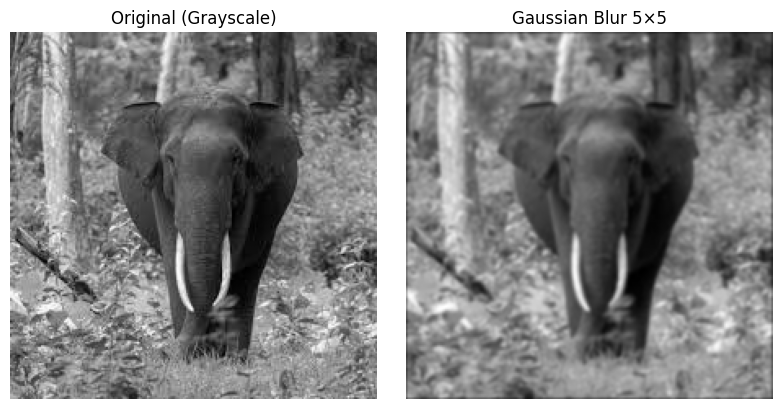

In [5]:
imgs = [gray, blur]
titles = [
    "Original (Grayscale)",
    "Gaussian Blur 5×5"
]

plt.figure(figsize=(16, 4))

for i, (img, title) in enumerate(zip(imgs, titles)):
    plt.subplot(1, 4, i + 1)
    plt.imshow(np.clip(img, 0, 255).astype(np.uint8), cmap="gray")
    plt.title(title)
    plt.axis("off")

plt.tight_layout()
plt.show()


#**2. Gradient Computation using Sobel Operators**

- Sobel-X computes horizontal intensity changes.
- Sobel-Y computes vertical intensity changes.
- The gradient magnitude represents edge strength.
- The gradient orientation represents edge direction.

These outputs are used in the non-maximum suppression step.

In [6]:
#The same Sobel kernels as Q2
sobel_x = np.array([
    [-1,  0,  1],
    [-2,  0,  2],
    [-1,  0,  1]
], dtype=np.float32)

sobel_y = np.array([
    [-1, -2, -1],
    [ 0,  0,  0],
    [ 1,  2,  1]
], dtype=np.float32)

Gx_manual = manual_convolution(blur, sobel_x)
Gy_manual = manual_convolution(blur, sobel_y)

magnitude_manual = np.sqrt(Gx_manual**2 + Gy_manual**2)
orientation_manual = np.arctan2(Gy_manual, Gx_manual)          # radians [-pi, pi]
ori_deg = orientation_manual * 180.0 / np.pi                   # degrees (for NMS / visualization)

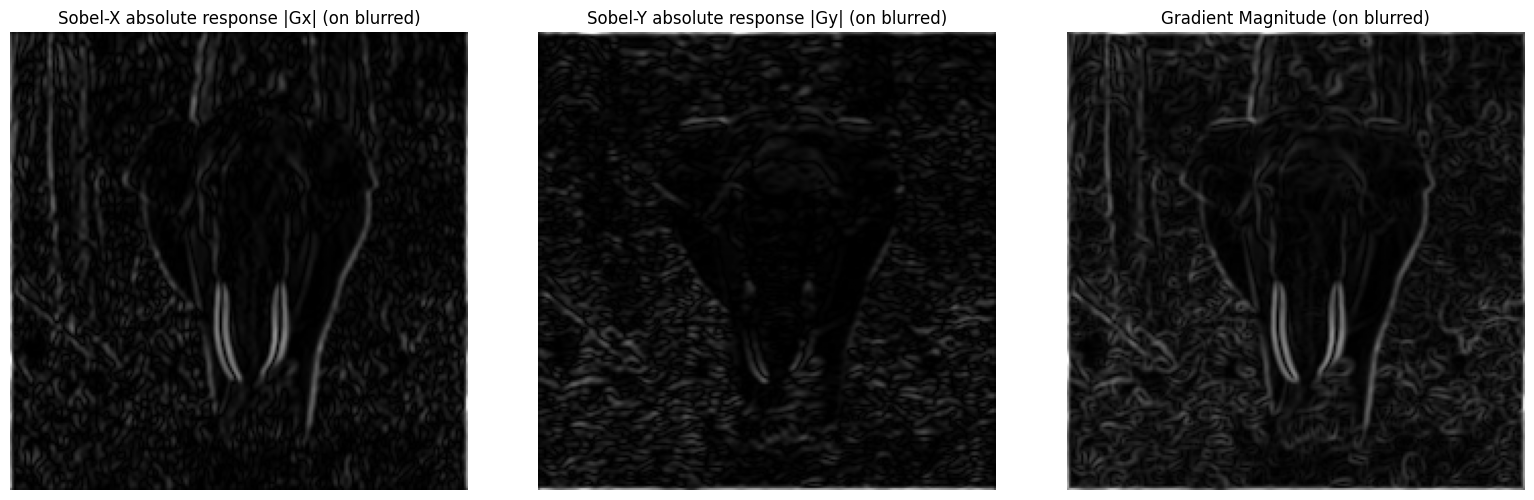

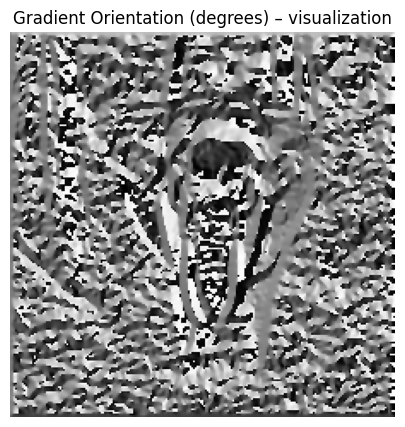

In [7]:
show_row(
    [
        normalize_0_255(np.abs(Gx_manual)),
        normalize_0_255(np.abs(Gy_manual)),
        normalize_0_255(magnitude_manual)
    ],
    [
        "Sobel-X absolute response |Gx| (on blurred)",
        "Sobel-Y absolute response |Gy| (on blurred)",
        "Gradient Magnitude (on blurred)"
    ]
)

plt.figure(figsize=(6,5))
plt.imshow(normalize_0_255(ori_deg), cmap="gray")
plt.title("Gradient Orientation (degrees) – visualization")
plt.axis("off")
plt.show()

#**3. Non-Maximum Suppression (NMS)**
NMS thins edges by keeping only **local maxima** along the gradient direction.

NMS is used to thin the edges by keeping only local maxima.
The gradient direction at each pixel is approximated to one of the main directions: 0°, 45°, 90°, or 135°.
Each pixel is compared to its two neighbors along the corresponding direction.
If the pixel is not a local maximum, it is suppressed.
The result is a thin edge map.


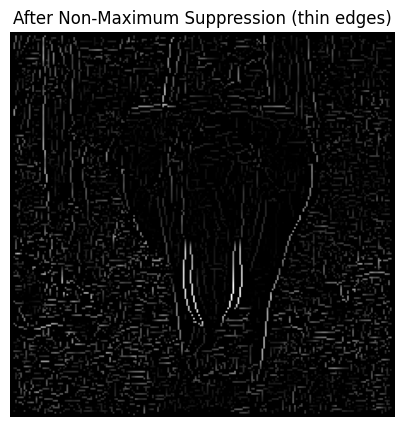

In [8]:
def non_max_suppression(grad_mag, grad_dir):
    H, W = grad_mag.shape
    Z = np.zeros((H, W), dtype=np.float32)

    angle = grad_dir % 180  # convert angles to [0–180)

    for i in range(1, H - 1):
        for j in range(1, W - 1):

            q = 0
            r = 0

            # 0 degrees
            if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                q = grad_mag[i, j+1]
                r = grad_mag[i, j-1]

            # 45 degrees
            elif (22.5 <= angle[i, j] < 67.5):
                q = grad_mag[i+1, j-1]
                r = grad_mag[i-1, j+1]

            # 90 degrees
            elif (67.5 <= angle[i, j] < 112.5):
                q = grad_mag[i+1, j]
                r = grad_mag[i-1, j]

            # 135 degrees
            elif (112.5 <= angle[i, j] < 157.5):
                q = grad_mag[i-1, j-1]
                r = grad_mag[i+1, j+1]

            # Keep only local maximum
            if (grad_mag[i, j] >= q) and (grad_mag[i, j] >= r):
                Z[i, j] = grad_mag[i, j]

    return Z

nms_result = non_max_suppression(magnitude_manual, ori_deg)

plt.figure(figsize=(6,5))
plt.imshow(normalize_0_255(nms_result), cmap="gray")
plt.title("After Non-Maximum Suppression (thin edges)")
plt.axis("off")
plt.show()

**Why Non-Maximum Suppression is essential?**

After computing the gradient magnitude, edges usually appear thick, meaning that several neighboring pixels respond strongly around the same edge.
Non-Maximum Suppression (NMS) is used to thin the edges by keeping only the pixel with the highest gradient value along the gradient direction, and suppressing the neighboring pixels.

As a result, wide edge responses are converted into thin, single-pixel edges, which makes the edge map clearer and more accurate.

#**4. Double Thresholding**

We classify pixels into:
- **Strong edges**: magnitude ≥ high threshold
- **Weak edges**: low <= magnitude < high
- **Non-edges**: magnitude < low

This step reduces noise (discard non-edges) while keeping weak candidates that may connect to strong edges.

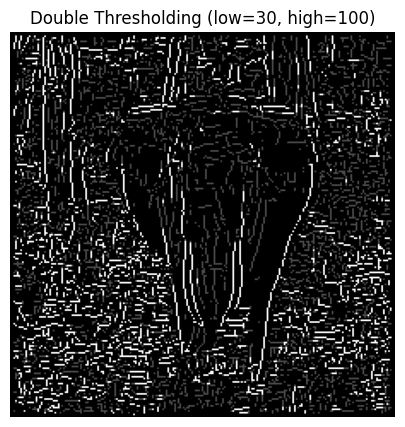

In [9]:
nms_val = nms_result.astype(np.float32)

low_threshold = 30
high_threshold = 100

strong_edges = (nms_val >= high_threshold)
weak_edges   = (nms_val >= low_threshold) & (nms_val < high_threshold)

thresholded = np.zeros_like(nms_val, dtype=np.uint8)
thresholded[weak_edges] = 75 #gray
thresholded[strong_edges] = 255 #white
#Non-edges stay black

plt.figure(figsize=(6,5))
plt.imshow(thresholded, cmap="gray")
plt.title("Double Thresholding (low=30, high=100)")
plt.axis("off")
plt.show()

**Why double thresholding helps remove noise and false
positives.**

Double thresholding helps because a single threshold is too “all-or-nothing”.
If we choose one high threshold, we might lose real edges that are a bit weaker (false negatives).
If we choose one low threshold, we keep a lot of noise responses (false positives).

With two thresholds, we separate pixels into:

Strong edges: definitely edges (above the high threshold).

Weak edges: possible edges (between low and high).

Non-edges: likely noise (below the low threshold).

Later, in hysteresis, weak edges are kept only if they are connected to strong edges.
This removes isolated noisy pixels while still keeping real edges that have weaker parts.

#**5.  Edge Tracking by Hysteresisg**

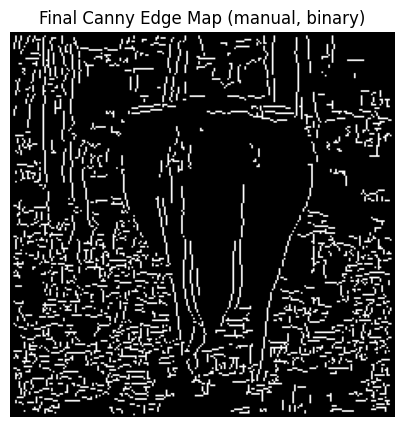

In [10]:
def hysteresis(thresholded):
    H, W = thresholded.shape
    res = thresholded.copy()

    # Find initial strong pixels
    strong_y, strong_x = np.where(res == 255)
    stack = list(zip(strong_y, strong_x))

    # 8-connectivity
    neighbors = [(-1,-1), (-1,0), (-1,1),
                 ( 0,-1),         ( 0,1),
                 ( 1,-1), ( 1,0), ( 1,1)]

    while stack:
        y, x = stack.pop()
        for dy, dx in neighbors:
            ny, nx = y + dy, x + dx
            if 0 <= ny < H and 0 <= nx < W:
                if res[ny, nx] == 75:          # weak connected to strong
                    res[ny, nx] = 255
                    stack.append((ny, nx))

    # Remove remaining weak pixels
    res[res != 255] = 0
    return res

final_edges = hysteresis(thresholded)

plt.figure(figsize=(6,5))
plt.imshow(final_edges, cmap="gray")
plt.title("Final Canny Edge Map (manual, binary)")
plt.axis("off")
plt.show()


**Why hysteresis is important?**

Edges in real images are often not equally strong along their entire length.
Some parts of the same edge may produce weaker gradients due to lighting or texture.

Hysteresis ensures that:

Continuous edges are preserved, even if parts of them are weak.

Isolated weak responses, which are usually noise, are removed.

This results in a cleaner and more reliable final edge map.

#**6. Compare to OpenCV Canny**

We compare our final result with OpenCV’s Canny.
Differences may come from:


different border handling
smoothing parameters
threshold selection
details of NMS/hysteresis implementation

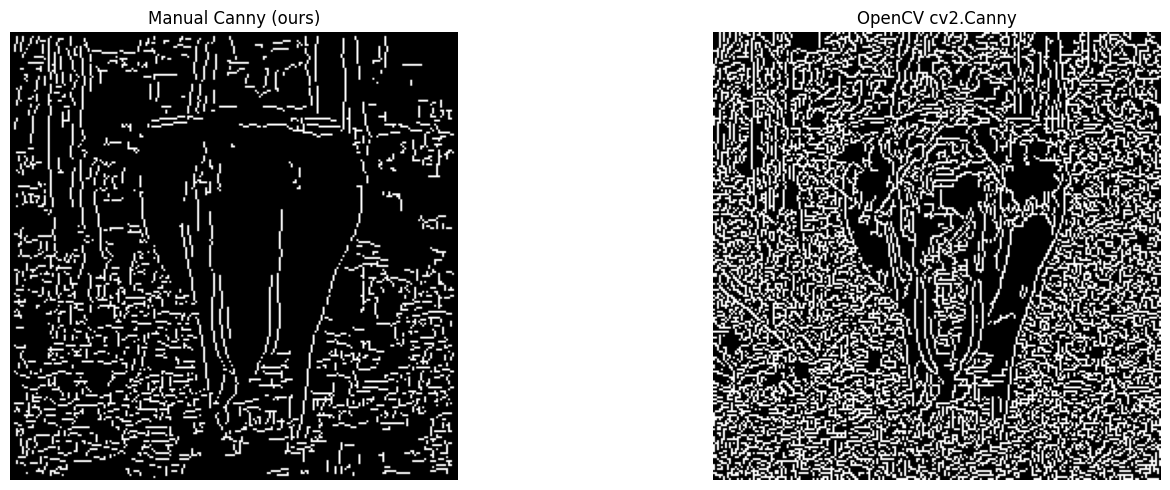

In [11]:
# Using the same numeric low/high values as our manual thresholds (note: OpenCV's internal scaling may differ)
##TODO check, and check if normalizes
canny_cv = cv2.Canny(gray.astype(np.uint8), low_threshold, high_threshold)

show_row(
    [final_edges, canny_cv],
    ["Manual Canny (ours)", "OpenCV cv2.Canny"]
)

**Explaining differences vs OpenCV Canny**

The difference between the manual Canny result and OpenCV’s cv2.Canny is expected.
OpenCV uses optimized internal implementations for Gaussian smoothing, gradient computation, non-maximum suppression, and hysteresis, which tend to preserve many weak responses and texture edges.

In contrast, the manual implementation applies stricter non-maximum suppression and simpler hysteresis, resulting in fewer detected edges and less noise.

Despite these differences, both results capture the main object contours, which indicates that the manual Canny pipeline was implemented correctly.